In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
import scipy.stats as stats
import cv2
from numba import jit, cuda 
import time
import random
import copy

In [2]:
class Pixel:
    def __init__(self, dim):
        self.data = []
        self.N_GMM = dim
        self.gmm = GaussianMixture(n_components=self.N_GMM)
         
    def updateH(self, num):
        self.data.append(num)
        
    def fitGMM(self):
        f = np.array(self.data).reshape(-1, 1)
        self.gmm.fit(f)
        w = self.gmm.weights_
        m = self.gmm.means_
        v = self.gmm.covariances_
        std = np.sqrt(v)
        self.para = np.hstack((w.reshape(-1, 1), m.reshape(-1, 1), std.reshape(-1, 1)))
        
    def eval_sep(self, num, w_threshold, std_threshold):
        # 0: background, 255: foreground
        k = -1
        min_val = 300
        for i in range(self.N_GMM):
            dif = abs(self.para[i][1] - num)
            if dif < min_val and dif < 2.5 * self.para[i][1]:
                min_val = dif
                k = i
        if k == -1:
            return 1
        w = self.para[k][0]
        std = self.para[k][2]
        if w < w_threshold and std > std_threshold:
            return 1
        else:
            return 0
        
    def eval_div(self, num, classify_threshold):
        # 0: background, 1: foreground
        k = -1
        min_val = 300
        for i in range(self.N_GMM):
            dif = abs(self.para[i][1] - num)
            if dif < min_val and dif < 2.5 * self.para[i][1]:
                min_val = dif
                k = i
        if k == -1:
            return 1
        w = self.para[k][0]
        std = self.para[k][2]
        if w/std < classify_threshold:
            return 1
        else:
            return 0
        
    def plotH(self):
        f = np.array(self.data).reshape(-1,1)
        plt.hist(f, histtype= 'bar',density=True, alpha=0.5)
        x = np.linspace(0, 255, 1000)
        for i in range(self.N_GMM):
            plt.plot(x, self.para[i][0] * stats.norm.pdf(x, self.para[i][1], self.para[i][2]))
        plt.show()



In [3]:
# resolution of video:
width = 120
height = 160

# hyperparameters
#pre-tracking
Pre_tra_N = 1150
Total_N = 5895
# dim of GMM
dim = 5

path = "source/traffic3"

In [4]:
screen = [[Pixel(dim) for i in range(height)] for j in range(width)]

for cnt in range(1,Pre_tra_N):
    frame = cv2.imread(f'{path}/{cnt}.jpg')
    gry = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    for i in range(height):
        for j in range(width):
            screen[j][i].updateH(int(gry[j][i]))
            

In [5]:
for i in range(height):
    for j in range(width):
        screen[j][i].fitGMM()

c:\Users\16923\anaconda3\envs\ML\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\16923\anaconda3\envs\ML\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\16923\anaconda3\envs\ML\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\16923\anaconda3\envs\ML\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known

In [57]:
def filter(org,width,height):
    bin_ = np.zeros((width,height))
    filter_frame1 = np.zeros((width,height)).astype(np.uint8)
    filter_frame2 = np.zeros((width,height)).astype(np.uint8)
    filter_frame3 = np.zeros((width,height)).astype(np.uint8)
    filter_frame4 = np.zeros((width,height)).astype(np.uint8)
    filter_frame5 = np.zeros((width,height)).astype(np.uint8)
    filter_frame6 = np.zeros((width,height,3)).astype(np.uint8)   
    for i in range(1,height-1):
        for j in range(1,width-1):
            if org[j][i] == 1:
                if (org[j-1][i]+org[j+1][i]+org[j][i-1]+org[j][i+1])<3:
                    filter_frame1[j][i] = 0
                else:
                    filter_frame1[j][i] = 1
    for i in range(1,height-1):
        for j in range(1,width-1):
            if filter_frame1[j][i] == 1:
                if (filter_frame1[j-1][i]+filter_frame1[j+1][i]+filter_frame1[j][i-1]+filter_frame1[j][i+1])<1:
                    filter_frame2[j][i] = 0
                else:
                    filter_frame2[j][i] = 1
    for i in range(1,height-1):
        for j in range(1,width-1):
            if filter_frame2[j][i] == 1:
                if (filter_frame2[j-1][i]+filter_frame2[j+1][i]+filter_frame2[j][i-1]+filter_frame2[j][i+1])<1:
                    filter_frame3[j][i] = 0
                else:
                    filter_frame3[j][i] = 1
    for i in range(1,height-1):
        for j in range(1,width-1):
            if filter_frame3[j][i] == 0:
                if (filter_frame3[j-1][i]+filter_frame3[j+1][i]+filter_frame3[j][i-1]+filter_frame3[j][i+1])>1:
                    filter_frame4[j][i] = 1
                else:
                    filter_frame4[j][i] = 0
            else:
                filter_frame4[j][i] = 1
    for i in range(1,height-1):
        for j in range(1,width-1):
            if filter_frame4[j][i] == 0:
                if (filter_frame4[j-1][i]+filter_frame4[j+1][i]+filter_frame4[j][i-1]+filter_frame4[j][i+1])>1:
                    filter_frame5[j][i] = 1
                else:
                    filter_frame5[j][i] = 0
            else:
                filter_frame5[j][i] = 1
                    
    for i in range(1,height-1):
        for j in range(1,width-1):
            if filter_frame5[j][i] == 0:
                if (filter_frame5[j-1][i]+filter_frame5[j+1][i]+filter_frame5[j][i-1]+filter_frame5[j][i+1])>1:
                    filter_frame6[j][i] = [255,255,255]
                    bin_[j][i] = 1
                else:
                    filter_frame6[j][i] = [0,0,0]
            else:
                filter_frame6[j][i] = [255,255,255]
                bin_[j][i] = 1
                    
    return filter_frame6, bin_

In [58]:
def optic_flow_check(i,j,org,prev):
    i1 = prev[j:j+15,i:i+15]
    i2 = org[j:j+15,i:i+15]
    dIm = np.float32(i2) - np.float32(i1)
    dIm[dIm <= 30] = 0
    dUm, dVm = np.gradient(np.float64(i2))
    dI = -1*dIm[j:j + 15, i:i + 15]
    dU = dUm[j:j + 15, i:i + 15]
    dV = dVm[j:j + 15, i:i + 15]
    dIv = dI.reshape(-1, 1)
    dUv = dU.reshape(-1, 1)
    dVv = dV.reshape(-1, 1)
    M = np.hstack((dVv, dUv))
    u = np.dot(np.linalg.pinv(M), dIv)
    return u


In [59]:
def plot_box(org,width,height,prev):
    count = copy.deepcopy(org)
    size = 0
    s = []
    e = []
    for i in range(height-10):
        for j in range(width-10):
            if count[j][i] == 1:
                b_h = int(0.7*j+15)
                b_w = int(0.6*b_h)
                if i <80:
                    jj = max(0,j - int(0.45*b_h))
                    ii = max(0,i - int(0.2*b_w))
                else:
                    jj = max(0,j - int(0.23*b_h))
                    ii = max(0,i - int(0.18*b_w))
                jj_ = min(width-1,jj+b_h)
                ii_ = min(height-1,ii+b_w)
                if np.sum(count[j:jj_,i:ii_])>2*j-5:
                    optic_flow_check(i,j,org,prev)
                    count[jj:jj_,ii:ii_] = 0
                    s.append((ii,jj))
                    e.append((ii_,jj_))
                    size += 1
    return s,e,size
    
                

In [63]:
# foreground/background classification
# # foreground: low w high std
classify_threshold = 0.01
w_threshold = 0.6
std_threshold = 10

# for cnt in range(Pre_tra_N,Total_N):
for cnt in range(1150,1690):
    for x in range(10):
        ri = random.randint(0, height-1)
        rj = random.randint(0, width-1)
        screen[rj][ri].fitGMM()
    BF_frame = np.zeros((width,height)).astype(np.uint8)
    frame = cv2.imread(f'{path}/{cnt}.jpg')
    gry = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    p= cv2.imread(f'{path}/{cnt-1}.jpg')
    prev = cv2.cvtColor(p, cv2.COLOR_BGR2GRAY)
    for i in range(height):
        for j in range(width):
            if screen[j][i].eval_div(gry[j][i],classify_threshold):
                BF_frame[j][i] = 1

    filter_frame, bin_= filter(BF_frame,width,height)
    start_v, end_v, size = plot_box(bin_,width,height,prev)
    
    combined_image = cv2.vconcat([frame, filter_frame])
    if size:
        for x in range(size):
            combined_image = cv2.rectangle(combined_image, start_v[x], end_v[x], (0, 255, 0) , 1) 
    combined_image = cv2.resize(combined_image, (height*3,width*4), interpolation=cv2.INTER_CUBIC)
    cv2.imshow('Binary Image', combined_image)
    cv2.waitKey(1)
    
cv2.destroyAllWindows()

c:\Users\16923\anaconda3\envs\ML\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\16923\anaconda3\envs\ML\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\16923\anaconda3\envs\ML\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
c:\Users\16923\anaconda3\envs\ML\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known

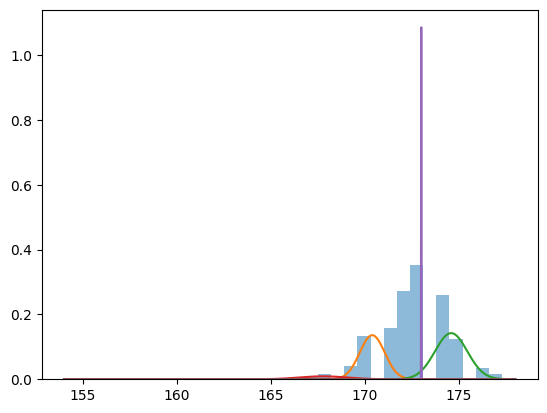

In [56]:
def plotH(s):
        f = np.array(s.data).reshape(-1,1)
        plt.hist(f, bins = 20, histtype= 'bar',density=True, alpha=0.5)
        x = np.linspace(min(s.data)-10, max(s.data), 1000)
        for i in range(s.N_GMM):
            plt.plot(x, s.para[i][0] * stats.norm.pdf(x, s.para[i][1], s.para[i][2]))
        plt.show()

test_val = 135
test_i = 86
test_j = 60
# print(screen[test_j][test_i].eval(135,classify_threshold,update_threshold))
plotH(screen[test_j][test_i])